In [ ]:
#Thư viện
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
batch_size = 128 # batch size để đưa vào mô hình huấn luyện
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data() #đọc dữ liệu
all_digits = np.concatenate([x_train, x_test]) 
all_digits = all_digits.astype("float32") / 255 #đưa tấm hình về [0,1]
all_digits = np.reshape(all_digits,(-1,28,28,1)) #reshape toàn bộ dữ liệu lại
dataset=tf.data.Dataset.from_tensor_slices(all_digits) #Đưa dữ liệu về dạng tensor
dataset = dataset.shuffle(buffer_size=1024).batch(batch_size).prefetch(32) #shuffle dữ liệu mỗi lần đưa vào mô hình

11493376/11490434 [==============================] - 0s 0us/step


# **1. DCGAN**

Generator

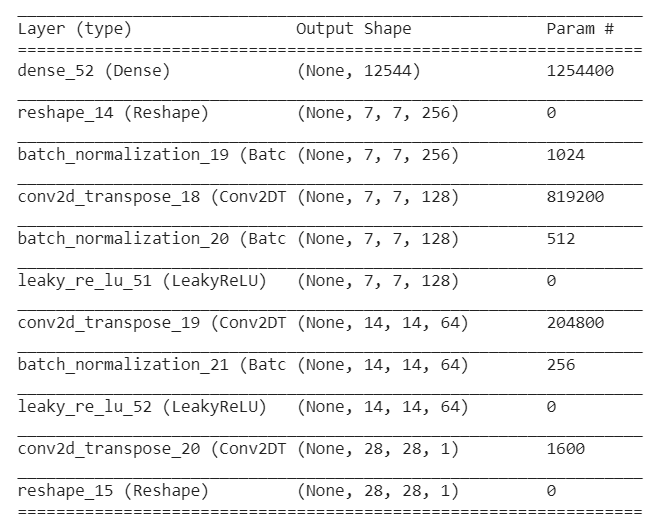

In [ ]:
# Mô hình của mạng Generator
latten_dim=128
generator=keras.Sequential()

generator.add(keras.Input(shape=(latten_dim,)))

generator.add(keras.layers.Dense(units=7*7*256, use_bias=False))
generator.add(keras.layers.Reshape((7,7,256)))

generator.add(keras.layers.BatchNormalization())
generator.add(tf.keras.layers.Conv2DTranspose(
        filters=128,
        kernel_size=5,
        strides=1,
        padding='same',
        use_bias=False
    ))

generator.add(keras.layers.BatchNormalization())
generator.add(keras.layers.LeakyReLU(alpha=0.3))

generator.add(tf.keras.layers.Conv2DTranspose(
        filters=64,
        kernel_size=5,
        strides=2,
        padding='same',
        use_bias=False
    ))
generator.add(keras.layers.BatchNormalization())

generator.add(keras.layers.LeakyReLU(alpha=0.3))
generator.add(tf.keras.layers.Conv2DTranspose(
        filters=1,
        kernel_size=5,
        strides=2,
        padding='same',
        use_bias=False
    ))

generator.add(keras.layers.Reshape((28,28,1)))


generator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 12544)             1605632   
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 256)         0         
_________________________________________________________________
batch_normalization (BatchNo (None, 7, 7, 256)         1024      
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 7, 7, 128)         819200    
_________________________________________________________________
batch_normalization_1 (Batch (None, 7, 7, 128)         512       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 14, 14, 64)        2

Discriminator

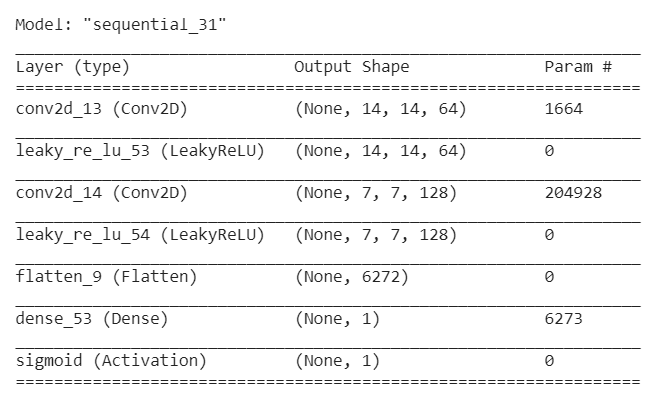

In [ ]:
# Mô hình của mạng Discrimimator
discriminator=keras.Sequential()

discriminator.add(keras.Input(shape=(28,28,1)))

discriminator.add(tf.keras.layers.Conv2D(
        filters=64,
        kernel_size=5,
        strides=2,
        padding='same',
        use_bias=True
    ))
discriminator.add(keras.layers.LeakyReLU(alpha=0.3))

discriminator.add(tf.keras.layers.Conv2D(
        filters=128,
        kernel_size=5,
        strides=2,
        padding='same',
        use_bias=True
    ))
discriminator.add(keras.layers.LeakyReLU(alpha=0.3))

discriminator.add(keras.layers.Flatten())

discriminator.add(keras.layers.Dense(1))

discriminator.add(keras.layers.Activation(activation="sigmoid",name="sigmoid"))  #do đây là mô hình dự đoán cho 2 nhãn nên dùng sigmoid

discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 14, 14, 64)        1664      
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 128)         204928    
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 7, 7, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 6272)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 6273      
_________________________________________________________________
sigmoid (Activation)         (None, 1)                

In [ ]:
class Gan(keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super(Gan,self).__init__()
        self.discriminator=discriminator 
        self.generator=generator
        self.latent_dim=latent_dim
    def compile(self, d_optimizer, g_optimizer, loss_function):
        super(Gan,self).compile()
        self.d_optimizer=d_optimizer
        self.g_optimizer=g_optimizer
        self.loss_function=loss_function 
    def train_step(self, real_images):
        # tạo batch size từ dữ liệu đầu vào
        batch_size = tf.shape(real_images)[0]
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim)) #tạo noises theo phân phối chuẩn

        # Tạo ra ảnh giả từ mạng generator
        generated_images = self.generator(random_latent_vectors)

        # nối ảnh giả và ảnh thật làm bộ dữ liệu cho mô hình discriminator
        combined_images = tf.concat([generated_images, real_images], axis=0)

        # Ở đây đánh nhãn ảnh thật là 1, ảnh giả là 0
        labels = tf.concat(
            [tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0
        )
        # trick để add thêm noise cho nhãn
        labels += 0.05 * tf.random.uniform(tf.shape(labels))

        # huấn luyện discriminator
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images) #Dự đoán 
            d_loss = self.loss_function(labels, predictions)  #Đưa kết quả dự đoán và grouth-truth vào hàm loss
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        ) #cập nhật weights cho mô hình discriminator


        # lặp lại bước tạo noise như ở trên
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        # tạo mộ bộ nhãn sao cho đều là 1 để đánh lừa discriminator
        misleading_labels = tf.zeros((batch_size, 1))

        # Train generator (lưu ý k update weights cho discriminator)
        with tf.GradientTape() as tape:
            predictions = self.discriminator(self.generator(random_latent_vectors))
            g_loss = self.loss_function(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))
        return {"d_loss": d_loss, "g_loss": g_loss}

In [ ]:
from IPython.display import Image, display
class GANMonitor(keras.callbacks.Callback):
    def __init__(self, num_img, latent_dim=128):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.normal(shape=(self.num_img, self.latent_dim)) #Tạo noises
        generated_images = self.model.generator(random_latent_vectors) #tạo ảnh
        generated_images *= 255 #Đưa ảnh về [0,255]
        generated_images.numpy() 

        print("epoch ",epoch)
        for i in range(self.num_img):
            img = keras.preprocessing.image.array_to_img(generated_images[i])
            # plt.imshow(img)
            display(img) #in ảnh
        # if (epoch == 49):
        #   print('Done')

In [ ]:
epochs = 150 #số epochs
latent_dim =128 #số chiều cho noises
gan = Gan(discriminator=discriminator, generator=generator, latent_dim=latent_dim)
gan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=0.0003,beta_1=0.5), 
    g_optimizer=keras.optimizers.Adam(learning_rate=0.0003,beta_1=0.5),
    loss_function=keras.losses.BinaryCrossentropy(),
)

gan.fit(
    dataset, epochs=epochs, callbacks=[GANMonitor(num_img=1, latent_dim=latent_dim)],verbose=0
    )

epoch  0


epoch  1


epoch  2


epoch  3


epoch  4


epoch  5


epoch  6


epoch  7


epoch  8


epoch  9


epoch  10


epoch  11


epoch  12


epoch  13


epoch  14


epoch  15


epoch  16


epoch  17


epoch  18


epoch  19


epoch  20


epoch  21


epoch  22


epoch  23


epoch  24


epoch  25


epoch  26


epoch  27


epoch  28


epoch  29


epoch  30


epoch  31


epoch  32


epoch  33


epoch  34


epoch  35


epoch  36


epoch  37


epoch  38


epoch  39


epoch  40


epoch  41


epoch  42


epoch  43


epoch  44


epoch  45


epoch  46


epoch  47


epoch  48


epoch  49


epoch  50


epoch  51


epoch  52


epoch  53


epoch  54


epoch  55


epoch  56


epoch  57


epoch  58


epoch  59


epoch  60


epoch  61


epoch  62


epoch  63


epoch  64


epoch  65


epoch  66


epoch  67


epoch  68


epoch  69


epoch  70


epoch  71


epoch  72


epoch  73


epoch  74


epoch  75


epoch  76


epoch  77


epoch  78


epoch  79


epoch  80


epoch  81


epoch  82


epoch  83


epoch  84


epoch  85


epoch  86


epoch  87


epoch  88


epoch  89


epoch  90


epoch  91


epoch  92


epoch  93


epoch  94


epoch  95


epoch  96


epoch  97


epoch  98


epoch  99


epoch  100


epoch  101


epoch  102


epoch  103


epoch  104


epoch  105


epoch  106


epoch  107


epoch  108


epoch  109


epoch  110


epoch  111


epoch  112


epoch  113


epoch  114


epoch  115


epoch  116


epoch  117


epoch  118


epoch  119


epoch  120


epoch  121


epoch  122


epoch  123


epoch  124


epoch  125


epoch  126


epoch  127


epoch  128


epoch  129


epoch  130


epoch  131


epoch  132


epoch  133


epoch  134


epoch  135


epoch  136


epoch  137


epoch  138


epoch  139


epoch  140


epoch  141


epoch  142


epoch  143


epoch  144


epoch  145


epoch  146


epoch  147


epoch  148


epoch  149


**Từ mô hình GAN đã huấn luyện hãy viết một hàm in ra 10 hình từ noises có phân phối chuẩn**

In [ ]:
def display_image(num_img, logs=None):
  random_latent_vectors = tf.random.normal(shape=(num_img, latent_dim)) #Tạo noises
  generated_images = gan.generator(random_latent_vectors) #tạo ảnh
  generated_images *= 255 #Đưa ảnh về [0,255]
  generated_images.numpy() 
  # print(generated_images.shape)

  plt.figure(figsize=(10,5))

  for i, image in enumerate(generated_images):
    img = keras.preprocessing.image.array_to_img(generated_images[i])
    plt.subplot(2,5,i+1)
    plt.imshow(img, cmap='gray')
    plt.axis('off')
  plt.show()

In [ ]:
display_image(num_img = 10)

# **2. CGAN**

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 512)               401920    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 512)               262656    
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 512)               262656    
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 512)              

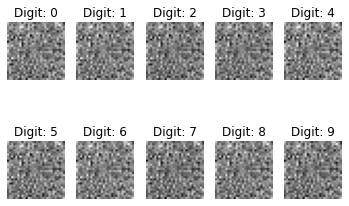

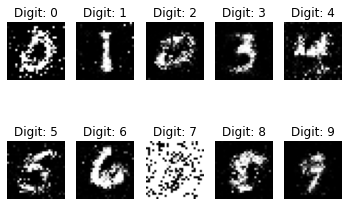

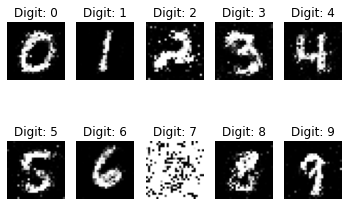

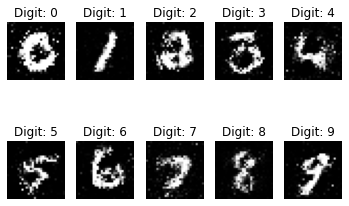

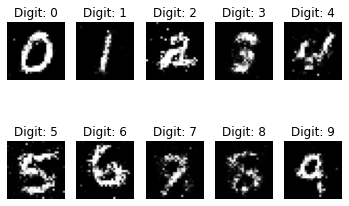

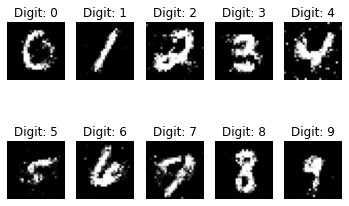

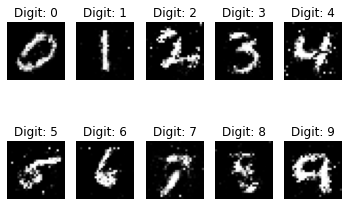

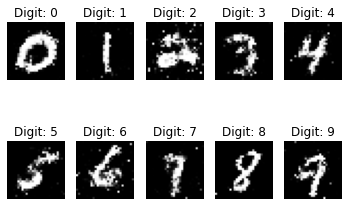

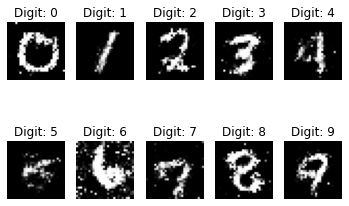

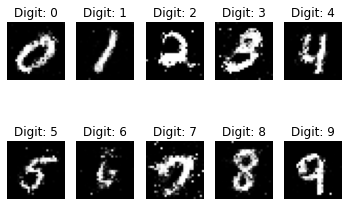

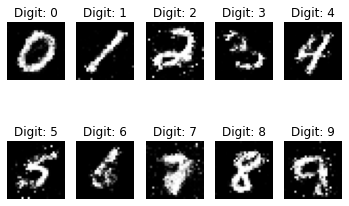

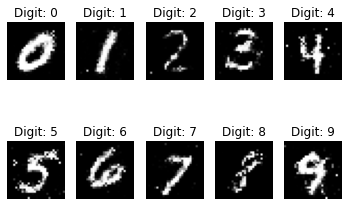

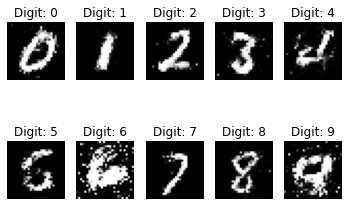

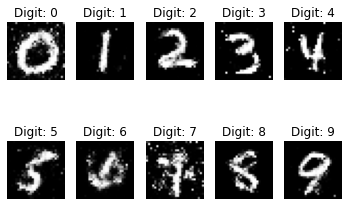

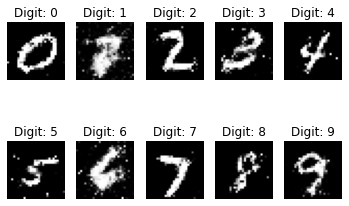

In [ ]:
%%time
from __future__ import print_function, division
from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, multiply
from keras.layers import BatchNormalization, Activation, Embedding, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam

import matplotlib.pyplot as plt

import numpy as np

class CGAN():
    def __init__(self):
        # Input shape
        img_shape = (28,28,1)
        self.img_shape = img_shape
        self.num_classes = 10
        self.latent_dim = 128

        optimizer = Adam(0.0002, 0.5)

        # Build and compile the discriminator
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss=['binary_crossentropy'],
            optimizer=optimizer,
            metrics=['accuracy'])

        # Build the generator
        self.generator = self.build_generator()

        # The generator takes noise and the target label as input
        # and generates the corresponding digit of that label
        noise = Input(shape=(self.latent_dim,))
        label = Input(shape=(1,))
        img = self.generator([noise, label])

        # For the combined model we will only train the generator
        self.discriminator.trainable = False

        # The discriminator takes generated image as input and determines validity
        # and the label of that image
        valid = self.discriminator([img, label])

        # The combined model  (stacked generator and discriminator)
        # Trains generator to fool discriminator
        self.combined = Model([noise, label], valid)
        self.combined.compile(loss=['binary_crossentropy'],
            optimizer=optimizer)

    def build_generator(self):

        model = Sequential()

        model.add(Dense(256, input_dim=self.latent_dim))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(1024))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(np.prod(self.img_shape), activation='tanh'))
        model.add(Reshape(self.img_shape))

        model.summary()

        noise = Input(shape=(self.latent_dim,))
        label = Input(shape=(1,), dtype='int32')
        label_embedding = Flatten()(Embedding(self.num_classes, self.latent_dim)(label))

        model_input = multiply([noise, label_embedding])
        img = model(model_input)

        return Model([noise, label], img)

    def build_discriminator(self):

        model = Sequential()

        model.add(Dense(512, input_dim=np.prod(self.img_shape)))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.4))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.4))
        model.add(Dense(1, activation='sigmoid'))
        model.summary()

        img = Input(shape=self.img_shape)
        label = Input(shape=(1,), dtype='int32')

        label_embedding = Flatten()(Embedding(self.num_classes, np.prod(self.img_shape))(label))
        flat_img = Flatten()(img)

        model_input = multiply([flat_img, label_embedding])

        validity = model(model_input)

        return Model([img, label], validity)

    def sample_images(self, epoch):
        r, c = 2, 5
        noise = np.random.normal(0, 1, (r * c, 128))
        sampled_labels = np.arange(0, 10).reshape(-1, 1)

        gen_imgs = self.generator.predict([noise, sampled_labels])

        # Rescale images [0,1]
        gen_imgs = 0.5 * gen_imgs + 0.5
        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                  axs[i,j].imshow(gen_imgs[cnt,:,:,0], cmap='gray')
                  axs[i,j].set_title("Digit: %d" % sampled_labels[cnt])
                  axs[i,j].axis('off')
                  cnt += 1

    def train(self, epochs, batch_size, sample_interval):

        # Load the dataset
        (X_train, y_train), (_, _) = mnist.load_data()

        # Configure input
        X_train = (X_train.astype(np.float32) - 127.5) / 127.5
        X_train = np.expand_dims(X_train, axis=3)
        y_train = y_train.reshape(-1, 1)

        # Adversarial ground truths
        valid = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))

        for epoch in range(epochs):

            #  Train Discriminator
      
            # Select a random half batch of images
            idx = np.random.randint(0, X_train.shape[0], batch_size)
            imgs, labels = X_train[idx], y_train[idx]

            # Sample noise as generator input
            noise = np.random.normal(0, 1, (batch_size, 128))

            # Generate a half batch of new images
            gen_imgs = self.generator.predict([noise, labels])

            # Train the discriminator
            d_loss_real = self.discriminator.train_on_batch([imgs, labels], valid)
            d_loss_fake = self.discriminator.train_on_batch([gen_imgs, labels], fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            #  Train Generator

            # Condition on labels
            sampled_labels = np.random.randint(0, 10, batch_size).reshape(-1, 1)

            # Train the generator
            g_loss = self.combined.train_on_batch([noise, sampled_labels], valid)

            # If at save interval => save generated image samples
            if epoch % sample_interval == 0:
                print ("Epoch: %d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))
                self.sample_images(epoch)

if __name__ == '__main__':
    cgan = CGAN()
    cgan.train(epochs=15000, batch_size=128, sample_interval=1000)

**Viết một hàm in ra danh sách các hình muốn in ra**

In [ ]:
def display_image_cgan(arr_label):
  noise = np.random.normal(0, 1, (len(arr_label), 128))
  arr_label = arr_label.reshape(-1, 1)
  gen_imgs = cgan.generator.predict([noise, arr_label])
  plt.figure(figsize=(10,5))

  for i, image in enumerate(gen_imgs):
    img = keras.preprocessing.image.array_to_img(gen_imgs[i])
    plt.subplot(2,len(arr_label)/2 + 1,i+1)
    plt.imshow(img, cmap='gray')
    plt.axis('off')
  plt.show()

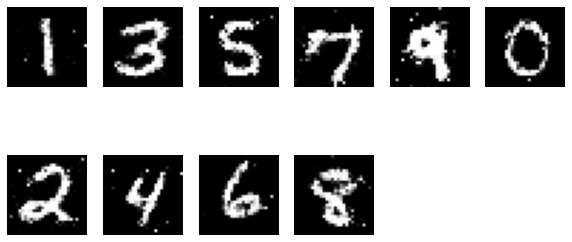

In [ ]:
labels = np.array([1,3,5,7,9,0,2,4,6,8])
display_image_cgan(labels)